# Identifying influential samples and parameters and evaluating their impact on a model's performance 

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
pylab.rcParams['figure.figsize'] = (8, 6)
matplotlib.rcParams.update({'font.size':16})

In [3]:
import numpy as np
import pandas as pd
import sys
import matplotlib.pyplot as plt
from timeit import default_timer as timer
import GraphConstruct as gc 
import GraphProcess as gp
from Utilities import Utilities as utils

In [4]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import tree, ensemble
from sklearn.preprocessing import minmax_scale

## Import data

In [5]:
util = utils()
#filename = "../../datasets/powerperf/new-data/kripke.16nodes.small_input.l0.norm.csv"
filename = "../../datasets/powerperf/binarized/kripke.16nodes.2000_input.l0.norm.binary.csv"

response = "ExecTime"
X_bin, y_bin = util.load_data(filename, response)
print X_bin.shape, y_bin.shape # Verify shape

# Drop unnecessary columns and normalize the data
# For non-binarized data
# feats_drop = ['Input', 'ScatteringOrder', 'Nodes', \
#               'DRAM_LIMIT','Layout', 'Method', 'DRAMPowerPerNode', 'ProcessorPower', \
#               'ProcessorPowerPerNode', 'DRAMPower', 'AvgTemp', 'AvgFreq',\
#               'AvgArithFpu','AvgInst','AvgIpc']

# For binarized data
feats_drop = ['Input_2000', 'ScatteringOrder_l0', 'Nodes_16', \
              'DRAM_LIMIT','Layout_0', 'Method_sweep', 'DRAMPowerPerNode', 'ProcessorPower', \
              'ProcessorPowerPerNode', 'DRAMPower', 'AvgTemp', 'AvgFreq',\
              'AvgArithFpu','AvgInst','AvgIpc',\
              'Input_12000', 'ScatteringOrder_l9', 'Nodes_64']

data_pd = util.data_norm(X_bin, y_bin, feats_drop=feats_drop, response_name='ExecTime', response_norm=False)
data_pd.head()

(17815, 29) (17815, 1)


,Ranks,Nesting_DGZ,Nesting_DZG,Nesting_GDZ,Nesting_GZD,Nesting_ZDG,Nesting_ZGD,Dset,Gset,OMP,PKG_LIMIT,ExecTime
0,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.50,7.6394
1,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.55,6.0149
2,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.60,5.4116
3,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.65,4.8056
4,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.70,4.6053


In [6]:
data_pd.dtypes

Ranks          float64
Nesting_DGZ    float64
Nesting_DZG    float64
Nesting_GDZ    float64
Nesting_GZD    float64
Nesting_ZDG    float64
Nesting_ZGD    float64
Dset           float64
Gset           float64
OMP            float64
PKG_LIMIT      float64
ExecTime       float64
dtype: object

In [7]:
# Convert datatypes of a few features to float (matters only for non-binarized data)
data_new = util.convert_pd_dtype(data_pd, ['PKG_LIMIT', 'OMP', 'Ranks', 'ExecTime'], totype='float64')

In [8]:
# Verify conversion and check shape of the dataframe
print data_new.dtypes
print data_new.shape
data_new.head()

Ranks          float64
Nesting_DGZ    float64
Nesting_DZG    float64
Nesting_GDZ    float64
Nesting_GZD    float64
Nesting_ZDG    float64
Nesting_ZGD    float64
Dset           float64
Gset           float64
OMP            float64
PKG_LIMIT      float64
ExecTime       float64
dtype: object
(17815, 12)


,Ranks,Nesting_DGZ,Nesting_DZG,Nesting_GDZ,Nesting_GZD,Nesting_ZDG,Nesting_ZGD,Dset,Gset,OMP,PKG_LIMIT,ExecTime
0,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.50,7.6394
1,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.55,6.0149
2,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.60,5.4116
3,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.65,4.8056
4,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,0.25,0.03125,0.333333,0.70,4.6053


In [9]:
data_new['ExecTime'].describe()

count    17815.000000
mean        26.505151
std         77.899932
min          1.001400
25%          3.004400
50%          5.044000
75%         13.264450
max       1304.506300
Name: ExecTime, dtype: float64

### Training and test splits

In [10]:
# Create data and response objects using a sample of the entire data
seed = 0 # set seed for reproducability (this seed is for sampling the data)
data_sample = data_pd.sample(frac=0.2, random_state=seed)
n_feat = data_sample.shape[1] - 1

# Training and test splits
train, test = train_test_split(data_sample, test_size=0.3, random_state=seed)
X_train, y_train = train.iloc[:, :n_feat], train.iloc[:, n_feat]
X_test, y_test = test.iloc[:, :n_feat], test.iloc[:, n_feat]

In [11]:
print X_train.shape, y_train.shape, X_test.shape, y_test.shape # Verify shapes

(2494, 11) (2494,) (1069, 11) (1069,)


In [12]:
X_train.head()

,Ranks,Nesting_DGZ,Nesting_DZG,Nesting_GDZ,Nesting_GZD,Nesting_ZDG,Nesting_ZGD,Dset,Gset,OMP,PKG_LIMIT
8501,0.250000,1.0,0.0,0.0,0.0,0.0,0.0,1.00,1.000,0.166667,0.65
6649,0.166667,0.0,0.0,0.0,1.0,0.0,0.0,0.50,0.500,0.166667,1.00
5271,0.166667,1.0,0.0,0.0,0.0,0.0,0.0,0.50,1.000,0.500000,0.85
6164,0.166667,0.0,0.0,1.0,0.0,0.0,0.0,0.25,0.125,0.333333,0.95
752,0.083333,1.0,0.0,0.0,0.0,0.0,0.0,1.00,0.125,1.000000,0.85


In [13]:
print "Y train min max + Y test min max"
print np.min(y_train), np.max(y_train), np.min(y_test), np.max(y_test)

Y train min max + Y test min max
1.0015 1164.9603 1.0017 947.7569


### Build a model (GBoosted or decision tree) on the data

In [14]:
# Gradient boosted model
params = {'n_estimators': 500, 'max_depth': 5, 'min_samples_split': 5,
         'learning_rate': 0.05, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

In [142]:
# # Decision tree
# params = {'criterion': 'mse', 'max_depth': 4, 'min_samples_split': 10, 
#          'random_state': seed}
# clf = tree.DecisionTreeRegressor(**params)

### Parameter influence analysis

In [20]:
def model_influence_analysis(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    pred_train = clf.predict(X_train)
    pred_test = clf.predict(X_test)
    mse_train = mean_squared_error(y_train, pred_train)
    mse_test = mean_squared_error(y_test, pred_test)
    r2_train = r2_score(y_train, pred_train)
    r2_test = r2_score(y_test, pred_test)
    #print "MSE train and test: %.8f %.8f" % (mse_train, mse_test)
    #print "R2 train and test:  %.8f %.8f" % (r2_train, r2_test)
    return mse_train, mse_test, r2_train, r2_test, pred_train, pred_test

In [21]:
# params_rf = {'n_estimators': 300, 'max_depth': 5, 'min_samples_split':5, 'random_state':0}
# clf_rf = ensemble.RandomForestRegressor(**params_rf)

In [22]:
# Perform cumulative/incremental feature influence analysis
n_feat = data_sample.shape[1] - 1
#colnames = data_sample.columns.values[:n_feat]
collist_sorted = ['Nesting_DGZ', 'Nesting_DZG', 'Nesting_GDZ', 'Nesting_GZD',
       'Nesting_ZDG', 'Nesting_ZGD', 'OMP', 'Gset', 'Dset', 'Ranks', 'PKG_LIMIT']
mse_train_list, mse_test_list, r2_train_list, r2_test_list, pred_train_list, pred_test_list = [{} for i in range(6)]

# By column name
for i, feat in enumerate(collist_sorted):
    print "Adding parameter: ", feat
    if i < 5: # Add all nesting params together
        continue
    mse_train_list[i], mse_test_list[i], r2_train_list[i], r2_test_list[i], pred_train_list[i], pred_test_list[i] = \
                                                              model_influence_analysis(clf,\
                                                              X_train[collist_sorted[:i+1]], \
                                                              y_train, X_test[collist_sorted[:i+1]], y_test)

Adding parameter:  Nesting_DGZ
Adding parameter:  Nesting_DZG
Adding parameter:  Nesting_GDZ
Adding parameter:  Nesting_GZD
Adding parameter:  Nesting_ZDG
Adding parameter:  Nesting_ZGD
Adding parameter:  OMP
Adding parameter:  Gset
Adding parameter:  Dset
Adding parameter:  Ranks
Adding parameter:  PKG_LIMIT


In [23]:
collist_noNest = ['Nesting', 'OMP', 'Gset', 'Dset', 'Ranks', 'PKG_LIMIT']

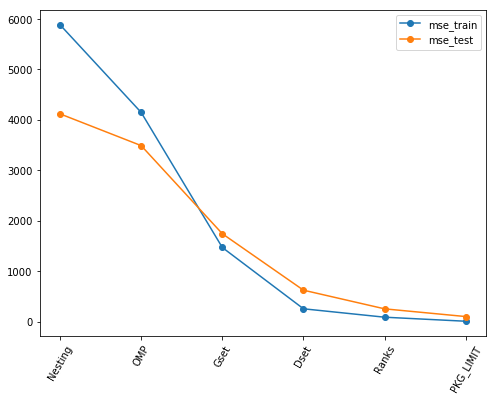

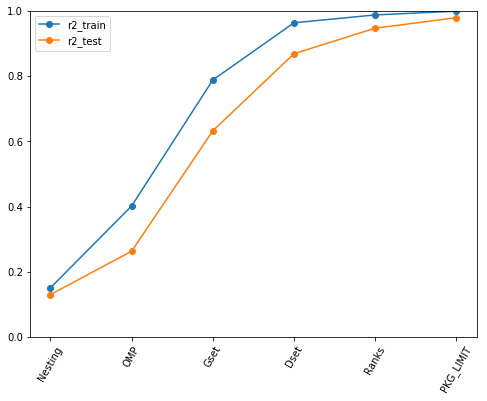

In [24]:
# Plot mse and r2 of train and test data
mse_lists = [mse_train_list, mse_test_list] 
r2_lists = [r2_train_list, r2_test_list]

matplotlib.rcParams.update({'font.size':10})
for i, curr_list in enumerate(mse_lists):
    plt.plot(np.arange(len(collist_noNest)), curr_list.values(), marker='o')
    plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
plt.legend(['mse_train', 'mse_test'])
plt.show()

for i, curr_list in enumerate(r2_lists):
    plt.plot(np.arange(len(collist_noNest)), curr_list.values(), marker='o')
    plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
    plt.ylim(0, 1)
plt.legend(['r2_train', 'r2_test'])
plt.show()

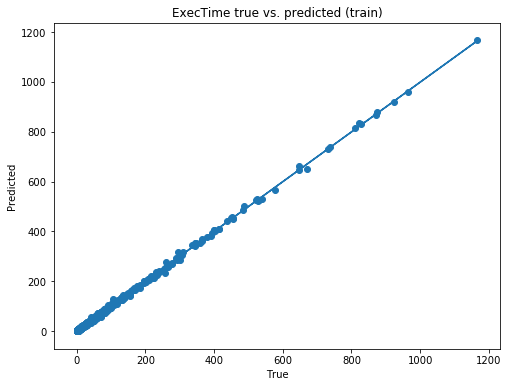

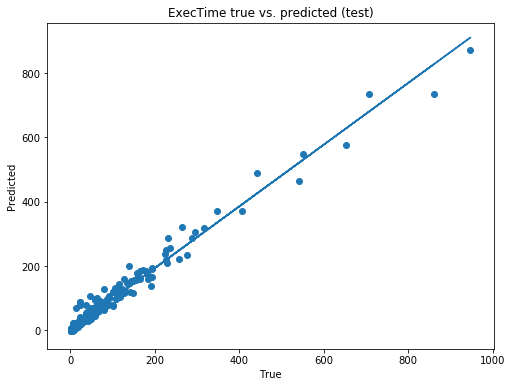

In [25]:
# Plot pred vs. actual
# Get the latest predictions
pred_train = pred_train_list[n_feat-1]
pred_test = pred_test_list[n_feat-1]
m, b = np.polyfit(y_train, pred_train, deg=1) # Linear best fit
plt.plot(y_train, m*y_train+b)
util.xy_plot(y_train, pred_train.reshape(len(pred_train))\
             , xlabel='True', ylabel='Predicted', title='ExecTime true vs. predicted (train)', \
             plot_type='scatter')

# Plot pred vs. actual
m, b = np.polyfit(y_test, pred_test, deg=1) # Linear best fit
plt.plot(y_test, m*y_test+b)
util.xy_plot(y_test, pred_test.reshape(len(pred_test))\
             , xlabel='True', ylabel='Predicted', title='ExecTime true vs. predicted (test)', \
             plot_type='scatter')

#### Perform inverse of above - start with all params and drop one by one

In [22]:
# Perform cumulative/incremental feature influence analysis
n_feat = data_sample.shape[1] - 1
# collist_reverse = ['PKG_LIMIT', 'Ranks', 'Dset','Gset', 'OMP', 'Nesting_DGZ', 'Nesting_DZG', \
#                    'Nesting_GDZ', 'Nesting_GZD', 'Nesting_ZDG', 'Nesting_ZGD']
collist_sorted = ['Nesting_DGZ', 'Nesting_DZG', 'Nesting_GDZ', 'Nesting_GZD',
       'Nesting_ZDG', 'Nesting_ZGD', 'OMP', 'Gset', 'Dset', 'Ranks', 'PKG_LIMIT']


mse_train_list_rev, mse_test_list_rev, r2_train_list_rev, r2_test_list_rev, pred_train_list_rev, pred_test_list_rev = \
    [{} for i in range(6)]

# By column name
for i, feat in enumerate(collist_sorted):
        
    #if i!=0:
    #    print "Removing parameter: ", feat
    
    if i < 6 and i!=0: # Remove all nesting params together
        continue
    print X_train[collist_sorted[i:n_feat]].shape
    mse_train_list_rev[i], mse_test_list_rev[i], r2_train_list_rev[i], r2_test_list_rev[i], pred_train_list_rev[i], \
    pred_test_list_rev[i] = model_influence_analysis(clf,\
                        X_train[collist_sorted[i:n_feat]], \
                        y_train, X_test[collist_sorted[i:n_feat]], y_test)

(2494, 11)
(2494, 5)
(2494, 4)
(2494, 3)
(2494, 2)
(2494, 1)


In [23]:
print r2_test_list_rev
print mse_test_list_rev

{0: 0.97930055582948583, 6: -0.65141818205862845, 7: -0.43783224562339873, 8: -0.021293098691299139, 9: 0.066521634043961941, 10: 0.0029922759394023224}
{0: 97.961988260121672, 6: 7815.4856348183839, 7: 6804.6709083340966, 8: 4833.3617907796715, 9: 4417.770640292094, 10: 4718.4290628828367}


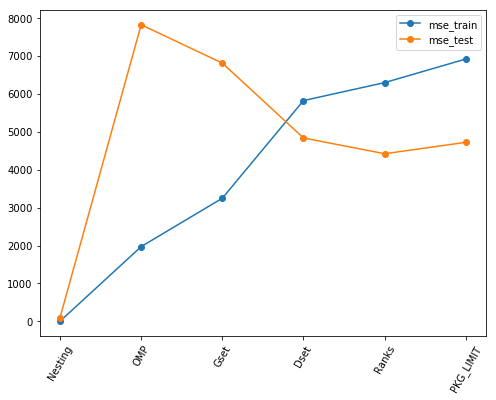

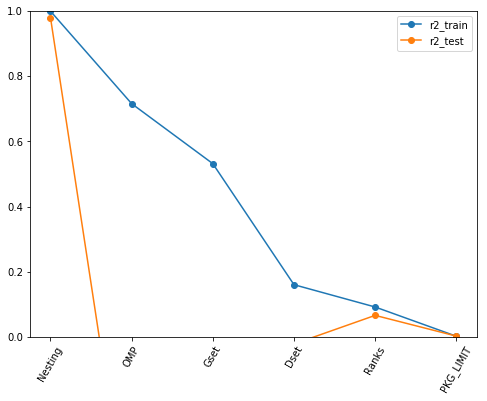

In [24]:
# Plot mse and r2 of train and test data
mse_lists = [mse_train_list_rev, mse_test_list_rev] 
r2_lists = [r2_train_list_rev, r2_test_list_rev]

matplotlib.rcParams.update({'font.size':10})
for i, curr_list in enumerate(mse_lists):
    plt.plot(np.arange(len(collist_noNest)), curr_list.values(), marker='o')
    plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
plt.legend(['mse_train', 'mse_test'])
plt.show()

for i, curr_list in enumerate(r2_lists):
    plt.plot(np.arange(len(collist_noNest)), curr_list.values(), marker='o')
    plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
    plt.ylim(0, 1)
plt.legend(['r2_train', 'r2_test'])
plt.show()

### Sample influence analysis

In [15]:
gp_obj = gp.GraphProcess()

Initalized object


In [16]:
# Compute Fourier frequency spectrum with all samples in the training data
start = timer()
xf, U, G = gp_obj.sample_influence_gft_sensitivity(domain=X_train, signal=y_train, \
                                        k_neighb=50, distance='Gower', noise=0.01)
end = timer()
print "Time elapsed = ", (end-start), "seconds"

Time elapsed =  14.2900738716 seconds


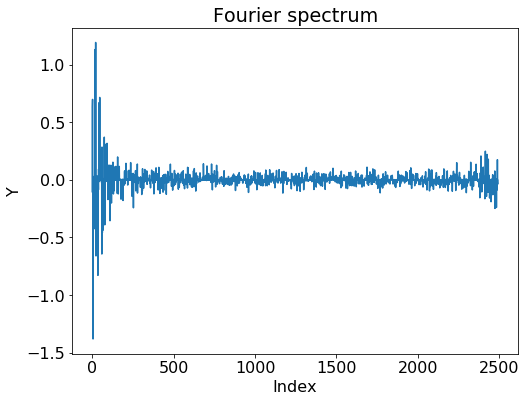

In [17]:
util.xy_plot(xf, marker=None, title='Fourier spectrum')

In [18]:
freq = 50
all_spectral_errors = []

# Iterate through the training data and modify samples one by one
for i in range(len(X_train)):
    y_train_copy = y_train.copy() # Create a copy of the original signal
    
    # Get neighbors of the current sample and compute the weighted mean of their signal value
    ngbrs = G.adj[i].keys()
    y_train_copy.iloc[i] = np.mean(y_train_copy.iloc[ngbrs]) 
    #y_train_copy.iloc[i] = np.median(y_train_copy.iloc[ngbrs])
    
#     weights = [1 - item['weight'] for item in G.adj[i].values()]
#     values = y_train_copy.iloc[ngbrs]
#     update = np.multiply(weights, values)
#     wtd_mean = np.mean(update)
#     y_train_copy.iloc[i] = wtd_mean
    
    modified_signal = minmax_scale(y_train_copy) # Normalize the new signal
    modified_xf = U.dot(modified_signal)         # Compute the modified frequency spectrum 
    
    # Compute the modified spectral error
    curr_error = np.abs(np.linalg.norm(xf[:freq])**2 - np.linalg.norm(modified_xf[:freq])**2)
    all_spectral_errors.append(curr_error)

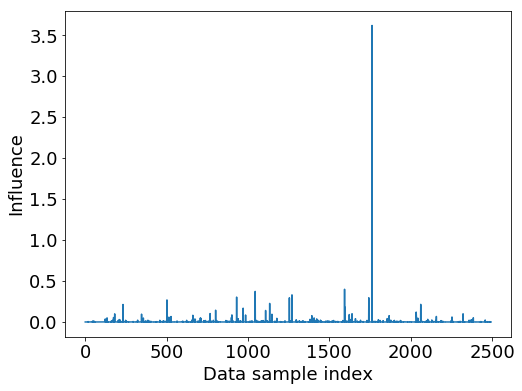

In [19]:
# How are the errors distributed?
matplotlib.rcParams.update({'font.size':18})
util.xy_plot(np.arange(len(all_spectral_errors)), all_spectral_errors, marker=None, \
             xlabel='Data sample index', ylabel='Influence', title='')

Sqd error vs. influence correlation
[[ 1.         0.0692702]
 [ 0.0692702  1.       ]]


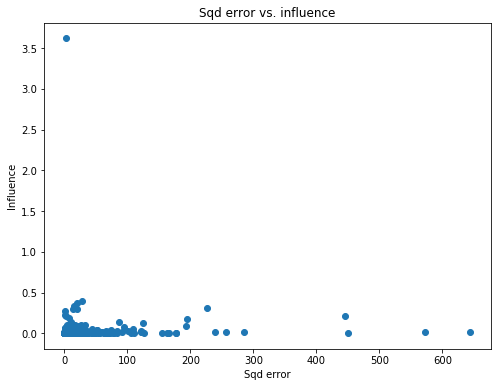

Signal vs. influence correlation
[[ 1.          0.50632802]
 [ 0.50632802  1.        ]]


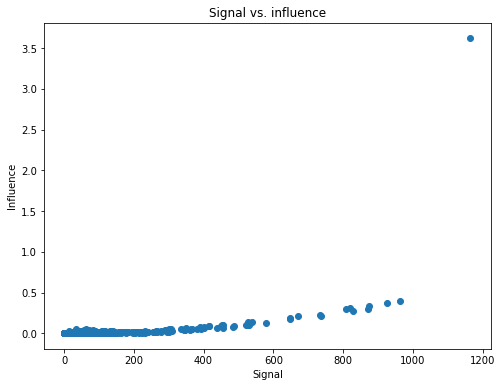

In [44]:
# Correlation of influences with model squared error
sqd_error = (y_train-pred_train)**2
print "Sqd error vs. influence correlation\n", np.corrcoef(sqd_error, all_spectral_errors)
util.xy_plot(sqd_error, all_spectral_errors, plot_type='scatter', xlabel='Sqd error', ylabel='Influence', \
            title='Sqd error vs. influence')

# Correlation of influences with signal value
print "Signal vs. influence correlation\n", np.corrcoef(y_train, all_spectral_errors)
util.xy_plot(y_train, all_spectral_errors, plot_type='scatter', xlabel='Signal', ylabel='Influence', \
            title='Signal vs. influence')

In [44]:
# Compute normalized influence
all_spectral_errors = 100*np.array(all_spectral_errors)/np.sum(all_spectral_errors)
print all_spectral_errors.shape

(2494,)


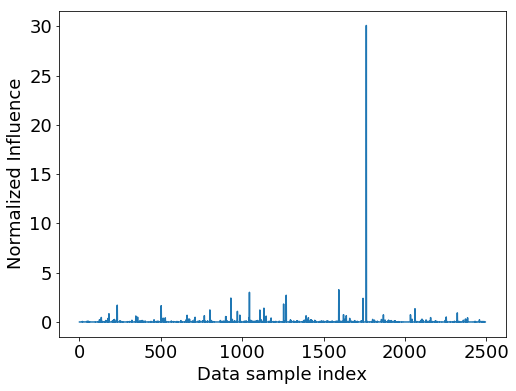

In [118]:
# Plot normalized influence
matplotlib.rcParams.update({'font.size':18})
util.xy_plot(np.arange(len(all_spectral_errors)), all_spectral_errors, marker=None, \
             xlabel='Data sample index', ylabel='Normalized Influence', title='')

In [46]:
np.sum(all_spectral_errors)

100.0

In [47]:
percentile = 95
value = np.percentile(all_spectral_errors, percentile)
outlier_idx = np.where(all_spectral_errors >= value)[0]
print "Number of samples above the ", percentile, "th percentile (", value, " ) ", "= ", len(outlier_idx)

Number of samples above the  95 th percentile ( 0.0997191744913  )  =  125


In [48]:
all_spectral_errors

array([  1.13270461e-04,   2.98732604e-04,   5.29079106e-05, ...,
         7.66744932e-03,   1.58827093e-04,   8.90643240e-05])

### Repeat model building without the outliers/influential samples

In [49]:
y_train.describe() # Original training signal

count    2494.000000
mean       27.277538
std        83.265678
min         1.001500
25%         3.004000
50%         5.206600
75%        12.818725
max      1164.960300
Name: ExecTime, dtype: float64

In [50]:
# What does the signal of the influential samples look like?
y_train.iloc[outlier_idx].describe()

count     125.000000
mean      274.235579
std       243.001604
min        13.618600
25%        80.096600
50%       199.011000
75%       392.752200
max      1164.960300
Name: ExecTime, dtype: float64

In [51]:
# Remove influential samples from the training data
X_train_copy = X_train.drop(X_train.index[outlier_idx])
y_train_copy = y_train.drop(y_train.index[outlier_idx])
print X_train_copy.shape, y_train_copy.shape

(2369, 11) (2369,)


In [52]:
# Perform cumulative/incremental feature influence analysis
n_feat = data_sample.shape[1] - 1
collist_sorted = ['Nesting_DGZ', 'Nesting_DZG', 'Nesting_GDZ', 'Nesting_GZD',
       'Nesting_ZDG', 'Nesting_ZGD', 'OMP', 'Gset', 'Dset', 'Ranks', 'PKG_LIMIT']
mse_train_list2, mse_test_list2, r2_train_list2, r2_test_list2, pred_train_list2, pred_test_list2 = \
        [{} for i in range(6)]

# By column name
for i, feat in enumerate(collist_sorted):
    print "Adding parameter: ", feat
    if i < 5: # Add all nesting params together
        continue
    mse_train_list2[i], mse_test_list2[i], r2_train_list2[i], r2_test_list2[i], pred_train_list2[i], \
    pred_test_list2[i] = model_influence_analysis(clf,\
                         X_train_copy[collist_sorted[:i+1]], \
                         y_train_copy, X_test[collist_sorted[:i+1]], y_test)

Adding parameter:  Nesting_DGZ
Adding parameter:  Nesting_DZG
Adding parameter:  Nesting_GDZ
Adding parameter:  Nesting_GZD
Adding parameter:  Nesting_ZDG
Adding parameter:  Nesting_ZGD
Adding parameter:  OMP
Adding parameter:  Gset
Adding parameter:  Dset
Adding parameter:  Ranks
Adding parameter:  PKG_LIMIT


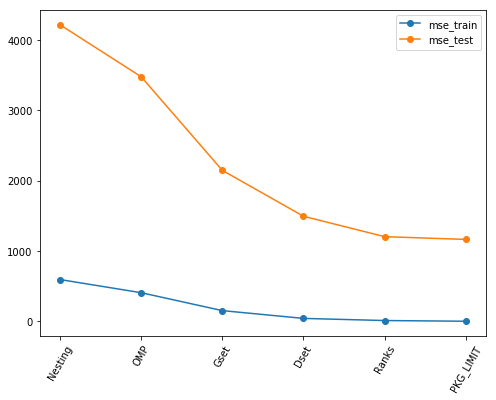

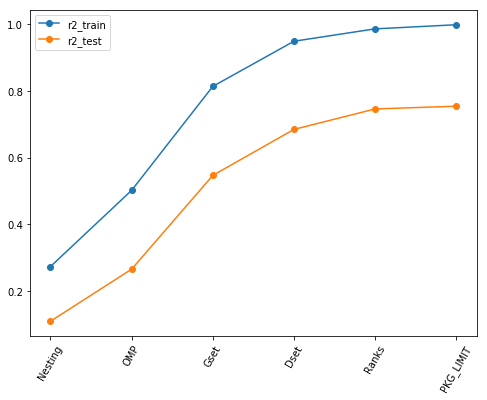

In [53]:
# Plot mse and r2 of train and test data
mse_lists2 = [mse_train_list2, mse_test_list2] 
r2_lists2 = [r2_train_list2, r2_test_list2]

matplotlib.rcParams.update({'font.size':10})
for i, curr_list in enumerate(mse_lists2):
    plt.plot(np.arange(len(collist_noNest)), curr_list.values(), marker='o')
    plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
plt.legend(['mse_train', 'mse_test'])
plt.show()

for i, curr_list in enumerate(r2_lists2):
    plt.plot(np.arange(len(collist_noNest)), curr_list.values(), marker='o')
    plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
plt.legend(['r2_train', 'r2_test'])
plt.show()

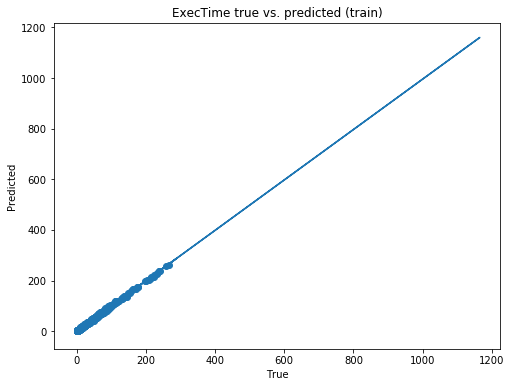

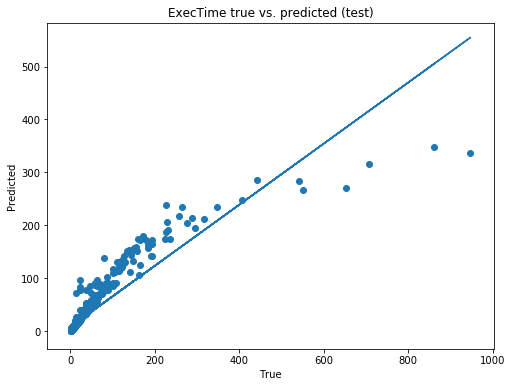

In [54]:
# Plot pred vs. actual
# Get the latest predictions
pred_train = pred_train_list2[n_feat-1]
pred_test = pred_test_list2[n_feat-1]
m, b = np.polyfit(y_train_copy, pred_train, deg=1) # Linear best fit
plt.plot(y_train, m*y_train+b)
util.xy_plot(y_train_copy, pred_train.reshape(len(pred_train))\
             , xlabel='True', ylabel='Predicted', title='ExecTime true vs. predicted (train)', \
             plot_type='scatter')

# Plot pred vs. actual
m, b = np.polyfit(y_test, pred_test, deg=1) # Linear best fit
plt.plot(y_test, m*y_test+b)
util.xy_plot(y_test, pred_test.reshape(len(pred_test))\
             , xlabel='True', ylabel='Predicted', title='ExecTime true vs. predicted (test)', \
             plot_type='scatter')

### Compare model performance with and without the influential samples

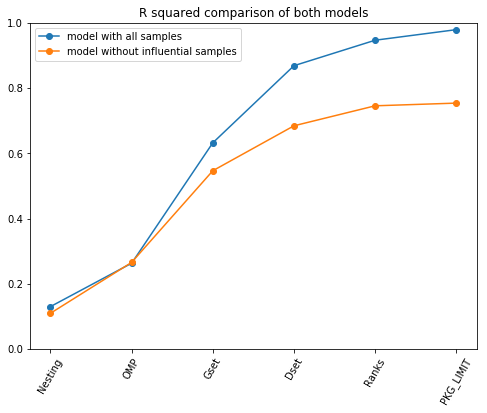

In [55]:
# R sqd of both models
plt.plot(arange(len(collist_noNest)), r2_test_list.values(), marker='o')
plt.plot(arange(len(collist_noNest)), r2_test_list2.values(), marker='o')
plt.legend(['model with all samples', 'model without influential samples'])
plt.title('R squared comparison of both models')
plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
plt.ylim(0, 1)
plt.show()

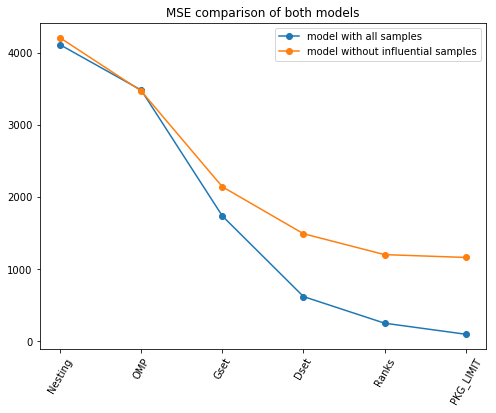

In [56]:
plt.plot(arange(len(collist_noNest)), mse_test_list.values(), marker='o')
plt.plot(arange(len(collist_noNest)), mse_test_list2.values(), marker='o')
plt.legend(['model with all samples', 'model without influential samples'])
plt.title('MSE comparison of both models')
plt.xticks(arange(len(collist_noNest)), collist_noNest, rotation=60)
plt.show()

When using the weighted mean of neighbors as opposed to just the mean/median, the difference in performance is less prominent, especially when using the first few parameters for building the model.

### Model performance variation with different # of influential vs. random samples 

In [62]:
# Influence-based outliers
sorted_outliers = np.argsort(-all_spectral_errors)
sorted_outliers

array([1762, 1593, 1044, ..., 1131, 1353, 2333])

In [68]:
# ExecTime outliers
exec_outliers = np.argsort(-y_train)
exec_outliers.head()

8501    1762
6649    1593
5271    1044
6164    1270
752     1254
Name: ExecTime, dtype: int64

In [110]:
def sample_drop_analysis(X_train, y_train, X_test, y_test, num_samples=[50, 100, 150], \
                         drop_type='influential', drop_idx=None):
    
    # Removing different # of influential samples
    num_samples = [50, 100, 150, 200, 250, 300]
    final_mse = []
    final_r2 = []

    for j, num in enumerate(num_samples):
        print "\nIteration:", j
        if drop_type == 'random':
            drop_idx = np.random.randint(0, len(X_train), size = num)
        
        X_train_copy = X_train.drop(X_train.index[drop_idx[:num]])
        y_train_copy = y_train.drop(y_train.index[drop_idx[:num]])
        print "X, y shape:", X_train_copy.shape, y_train_copy.shape

        mse_train_curr, mse_test_curr, r2_train_curr, r2_test_curr, \
            pred_train_curr, pred_test_curr = model_influence_analysis(clf, X_train_copy, y_train_copy, X_test, y_test)
        
        final_mse.append(mse_test_curr)
        final_r2.append(r2_test_curr)
            
    return final_mse, final_r2

In [115]:
num_samples = [50, 100, 150, 200, 250, 300]

# Drop influential samples
final_mse_inf, final_r2_inf = sample_drop_analysis(X_train, y_train, X_test, y_test, num_samples=num_samples,\
                                                    drop_type='influential', drop_idx=sorted_outliers)
# Drop exectime outliers
final_mse_exec, final_r2_exec= sample_drop_analysis(X_train, y_train, X_test, y_test, num_samples=num_samples,\
                                                    drop_type='influential', drop_idx=exec_outliers)
# Drop random samples
final_mse_rand, final_r2_rand= sample_drop_analysis(X_train, y_train, X_test, y_test, num_samples=num_samples,\
                                                    drop_type='random', drop_idx=None)


Iteration: 0
X, y shape: (2444, 11) (2444,)

Iteration: 1
X, y shape: (2394, 11) (2394,)

Iteration: 2
X, y shape: (2344, 11) (2344,)

Iteration: 3
X, y shape: (2294, 11) (2294,)

Iteration: 4
X, y shape: (2244, 11) (2244,)

Iteration: 5
X, y shape: (2194, 11) (2194,)

Iteration: 0
X, y shape: (2444, 11) (2444,)

Iteration: 1
X, y shape: (2394, 11) (2394,)

Iteration: 2
X, y shape: (2344, 11) (2344,)

Iteration: 3
X, y shape: (2294, 11) (2294,)

Iteration: 4
X, y shape: (2244, 11) (2244,)

Iteration: 5
X, y shape: (2194, 11) (2194,)

Iteration: 0
X, y shape: (2444, 11) (2444,)

Iteration: 1
X, y shape: (2394, 11) (2394,)

Iteration: 2
X, y shape: (2349, 11) (2349,)

Iteration: 3
X, y shape: (2300, 11) (2300,)

Iteration: 4
X, y shape: (2257, 11) (2257,)

Iteration: 5
X, y shape: (2215, 11) (2215,)


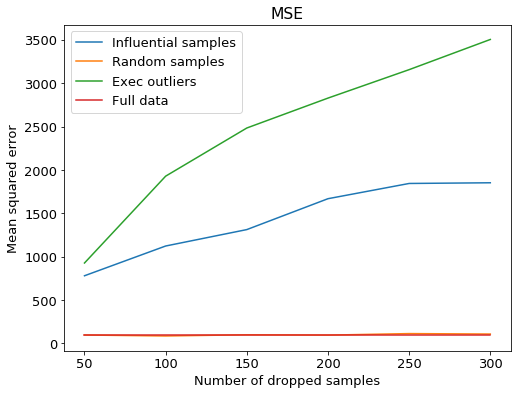

In [116]:
# Plot MSE of all cases (benchmarked with MSE with full data)
matplotlib.rcParams.update({'font.size':13})
plt.plot(num_samples, final_mse_inf)
plt.plot(num_samples, final_mse_rand)
plt.plot(num_samples, final_mse_exec)
all_samples_mse = [mse_test_list.values()[5]]*len(num_samples)
plt.plot(num_samples, all_samples_mse)
plt.title('MSE')
plt.xlabel('Number of dropped samples')
plt.ylabel('Mean squared error')
plt.legend(['Influential samples', 'Random samples', 'Exec outliers', 'Full data'])

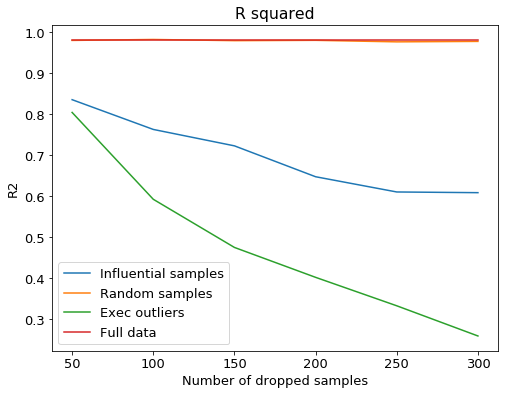

In [117]:
# Plot R2 of all cases (benchmarked with R2 with full data)
plt.plot(num_samples, final_r2_inf)
plt.plot(num_samples, final_r2_rand)
plt.plot(num_samples, final_r2_exec)
all_samples_r2 = [r2_test_list.values()[5]]*len(num_samples)
plt.plot(num_samples, all_samples_r2)
plt.title('R squared')
plt.xlabel('Number of dropped samples')
plt.ylabel('R2')
plt.legend(['Influential samples', 'Random samples', 'Exec outliers', 'Full data'])

### Histogram of parameters in influential samples

In [158]:
X_train.index[sorted_outliers[:1]][0]

4737

In [170]:
inf_samples = X_train.ix[X_train.index[sorted_outliers[:200]]]

In [172]:
inf_samples.head()

,Ranks,Nesting_DGZ,Nesting_DZG,Nesting_GDZ,Nesting_GZD,Nesting_ZDG,Nesting_ZGD,Dset,Gset,OMP,PKG_LIMIT
4737,0.083333,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,0.55
3947,0.083333,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.000000,0.65
3948,0.083333,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.000000,0.70
3749,0.083333,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.833333,0.65
4741,0.083333,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.000000,0.75


WIP

### Differences in spectra - weak vs. strong sample

In [205]:
freq = 50
strong_weak_idx = [sorted_outliers[0], sorted_outliers[len(sorted_outliers)-1]]

for i, idx in enumerate(strong_weak_idx):
    y_train_copy = y_train.copy() # Create a copy of the original signal
    print idx, 
    # Get neighbors of the current sample and compute the weighted mean of their signal value
    ngbrs = G.adj[idx].keys()
    y_train_copy.iloc[idx] = np.mean(y_train_copy.iloc[ngbrs]) 
    
    modified_signal = minmax_scale(y_train_copy) # Normalize the new signal
    modified_xf = U.dot(modified_signal)         # Compute the modified frequency spectrum 
    if i == 0:
        xf_strong = modified_xf
    else:
        xf_weak = modified_xf
    curr_error = np.abs(np.linalg.norm(xf[:freq])**2 - np.linalg.norm(modified_xf[:freq])**2)
    print curr_error

1762 3.64807027881
1405 1.93640126156e-09


In [206]:
print strong_weak_idx

[1762, 1405]


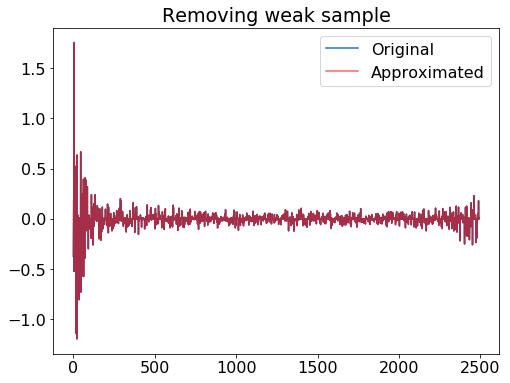

In [211]:
# Plot the original and approximate spectrums
plt.plot(xf, label='Original')
plt.plot(xf_weak, 'r', label='Approximated', alpha=0.6)
plt.legend(loc='best')
plt.title('Removing weak sample')
plt.show()

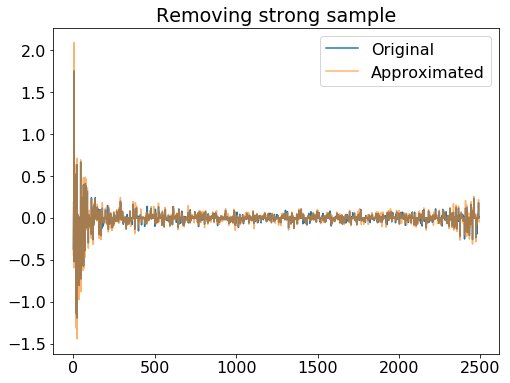

In [212]:
plt.plot(xf, label='Original')
plt.plot(xf_strong, label='Approximated', alpha=0.6)
plt.legend(loc='best')
plt.title('Removing strong sample')
plt.show()

Differences are not really visible (which is to be expected given the fact that the highest error is only around 3.64) 
<br>Note - in the sample influence plot shown previously, the highest error was around 29, this is because of the transformation done on the spectral errors to show them as a percentage.

### Use model with all parameters and test influence at different percentile values

In [35]:
# Test influence of samples on model performance at different percentile values
def influence_percentile_test(clf, X_train, y_train, X_test, y_test, influences):
    mse_test_list = []
    r2_test_list = []
    
    for i in range(100):
        print "\n", i
        idx1 = np.where(influences >= np.percentile(influences, 99-i))
        idx2 = np.where(influences <= np.percentile(influences, 99-i+1))
        idx = list(set(idx1[0]).intersection(idx2[0]))
        X_train_copy = X_train.drop(X_train.index[idx])
        y_train_copy = y_train.drop(y_train.index[idx])
        
        mse_train, mse_test, r2_train, r2_test, pred_train, pred_test =\
            model_influence_analysis(clf, X_train_copy, y_train_copy, X_test, y_test)
        mse_test_list.append(mse_test)
        r2_test_list.append(r2_test)
    return mse_test_list, r2_test_list

In [36]:
mse_test_list_perc, r2_test_list_perc = influence_percentile_test(clf, X_train, y_train,\
                                                                  X_test, y_test, all_spectral_errors)


0
MSE train and test: 0.76507888 3013.69270241
R2 train and test:  0.99933872 0.67630200

1
MSE train and test: 1.01048612 1100.58789048
R2 train and test:  0.99968091 0.88178685

2
MSE train and test: 1.06617188 891.90722763
R2 train and test:  0.99969857 0.90420105

3
MSE train and test: 1.71519478 791.31922275
R2 train and test:  0.99952854 0.91500512

4
MSE train and test: 1.64756425 1011.38655041
R2 train and test:  0.99954959 0.89136789

5
MSE train and test: 1.76237973 867.18488609
R2 train and test:  0.99952049 0.90685646

6
MSE train and test: 1.44143929 1293.97675072
R2 train and test:  0.99960696 0.86101513

7
MSE train and test: 1.54857102 829.86156654
R2 train and test:  0.99957693 0.91086532

8
MSE train and test: 1.37829228 972.32756668
R2 train and test:  0.99962427 0.89556318

9
MSE train and test: 1.68079157 817.75441911
R2 train and test:  0.99954204 0.91216574

10
MSE train and test: 1.48103719 831.98532021
R2 train and test:  0.99959791 0.91063721

11
MSE train an

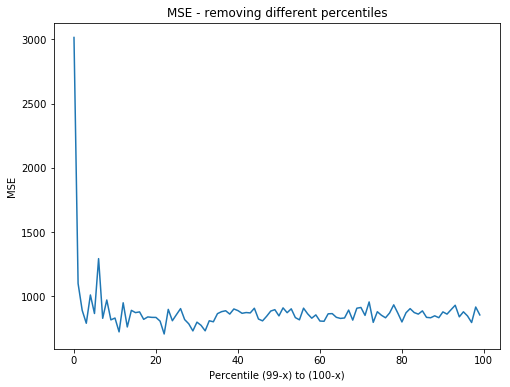

In [45]:
util.xy_plot(np.arange(len(mse_test_list_perc)), mse_test_list_perc, xlabel='Percentile (99-x) to (100-x)',\
             marker=None, title='MSE - removing different percentiles', ylabel='MSE')

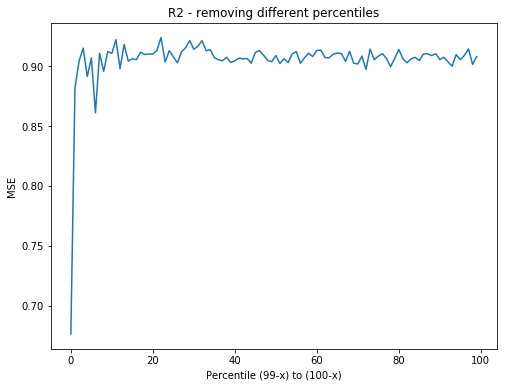

In [46]:
util.xy_plot(np.arange(len(r2_test_list_perc)), r2_test_list_perc, xlabel='Percentile (99-x) to (100-x)',\
             marker=None, title='R2 - removing different percentiles', ylabel='R2')

## Compare model-agnostic influence pattern with model-based pattern

In [162]:
# Function to plot feature importance

def plot_feature_importance(feature_importance, colnames):
    # Sourced from sklearn's documentation
    # Make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.argsort(feature_importance)
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.subplot(1, 2, 2)
    plt.barh(pos, feature_importance[sorted_idx], align='center')
    plt.yticks(pos, colnames[sorted_idx])
    plt.xlabel('Relative Importance')
    plt.title('Parameter Importance')
    plt.show()

In [164]:
colnames = X_train.columns.values

#### Gradient boosting model

In [163]:
clf1 = clf
clf1.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.05, loss='ls', max_depth=5, max_features=None,
             max_leaf_nodes=None, min_impurity_split=1e-07,
             min_samples_leaf=1, min_samples_split=5,
             min_weight_fraction_leaf=0.0, n_estimators=500,
             presort='auto', random_state=None, subsample=1.0, verbose=0,
             warm_start=False)

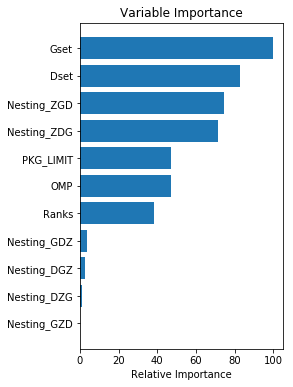

In [165]:
plot_feature_importance(clf1.feature_importances_, colnames)

In [237]:
print clf1.score(X_train, y_train)
print clf1.score(X_test, y_test)

0.999232308814
0.979291992117


#### Linear regression

In [141]:
from sklearn.linear_model import LinearRegression

In [142]:
clf2 = LinearRegression()

In [143]:
clf2.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [193]:
print clf2.score(X_train, y_train)
print clf2.score(X_test, y_test)

0.337728743796
0.272720912959


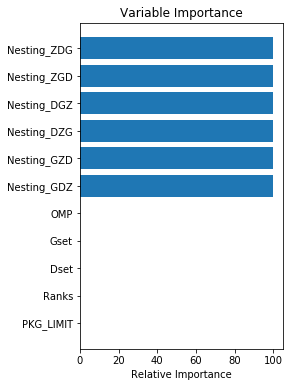

In [166]:
plot_feature_importance(clf2.coef_, colnames)

#### Random forests

In [157]:
params = {'n_estimators': 100, 'max_depth': 5, 'min_samples_split':5, 'random_state':0}
clf3 = ensemble.RandomForestRegressor(**params)

In [158]:
clf3.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_split=1e-07, min_samples_leaf=1,
           min_samples_split=5, min_weight_fraction_leaf=0.0,
           n_estimators=100, n_jobs=1, oob_score=False, random_state=0,
           verbose=0, warm_start=False)

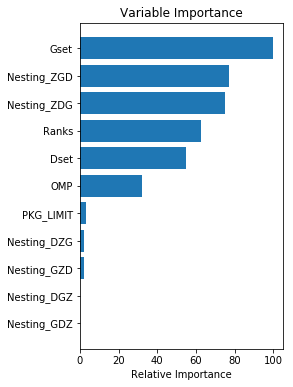

In [167]:
plot_feature_importance(clf3.feature_importances_, colnames)

In [236]:
print clf3.score(X_train, y_train)
print clf3.score(X_test, y_test)

0.937410304327
0.891054696937


#### Lasso

In [223]:
from sklearn.linear_model import Lasso

In [231]:
clf4 = Lasso(alpha=1.5, random_state=0, positive=True)
clf4 = Lasso(alpha=1.5, random_state=0, positive=False)
clf4.fit(X_train, y_train)

Lasso(alpha=1.5, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=0,
   selection='cyclic', tol=0.0001, warm_start=False)

In [232]:
print clf4.score(X_train, y_train)
print clf4.score(X_test, y_test)

0.322591862974
0.288189828152


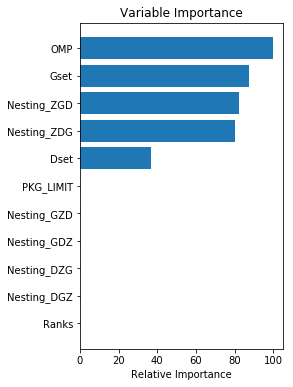

In [234]:
plot_feature_importance(clf4.coef_, colnames)